## Diffusion Pseudotime 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
pbmc = sc.read_10x_mtx('R/data/filtered_gene_bc_matrices/hg19/',
                       var_names = 'gene_symbols',
                       cache = True)

In [3]:
pbmc.var_names_make_unique()

In [4]:
pbmc

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

### Pre-processing: QC

Identify mitochondiral specific genes

In [5]:
pbmc.var['mt'] = pbmc.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(pbmc, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Visualize the QC metrics

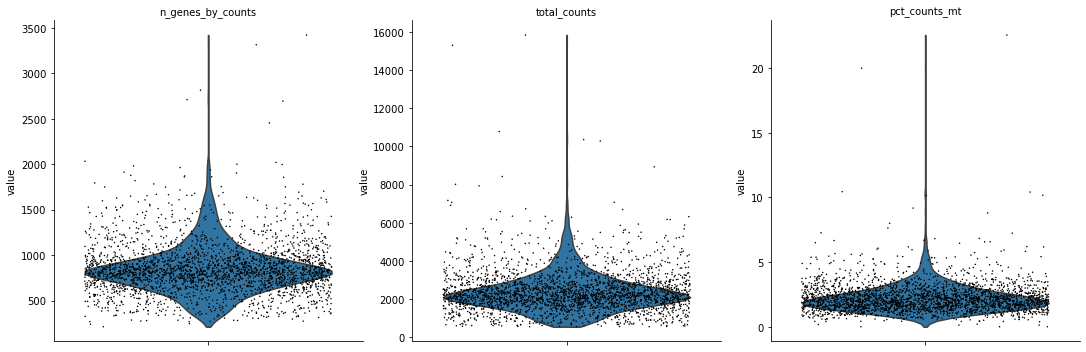

In [6]:
sc.pl.violin(pbmc, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, size = 1.5)

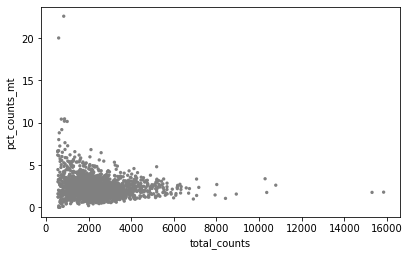

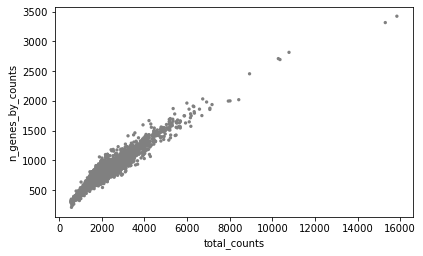

In [7]:
sc.pl.scatter(pbmc, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(pbmc, x='total_counts', y='n_genes_by_counts')

Filter out cells that have <200 or > 2500 genes.

In [8]:
sc.pp.filter_cells(pbmc, min_genes = 200)
sc.pp.filter_cells(pbmc, max_genes = 2500)
pbmc = pbmc[pbmc.obs.pct_counts_mt < 5, :]

In [9]:
pbmc

View of AnnData object with n_obs × n_vars = 2638 × 32738
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Normalize & log-transform

In [10]:
sc.pp.normalize_total(pbmc, target_sum=1e4)

/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [11]:
sc.pp.log1p(pbmc)

### Feature Selection

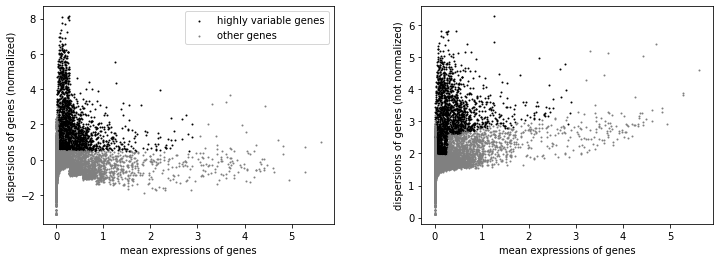

In [12]:
sc.pp.highly_variable_genes(pbmc, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(pbmc)

In [13]:
# filter to keep only HVGs
pbmc = pbmc[:, pbmc.var.highly_variable]

In [14]:
pbmc

View of AnnData object with n_obs × n_vars = 2638 × 2013
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

### Scale expression

In [15]:
sc.pp.scale(pbmc, max_value = 10)

/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


### PCA

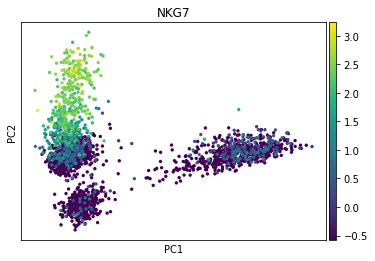

In [16]:
sc.tl.pca(pbmc, svd_solver='arpack')
sc.pl.pca(pbmc, color='NKG7')

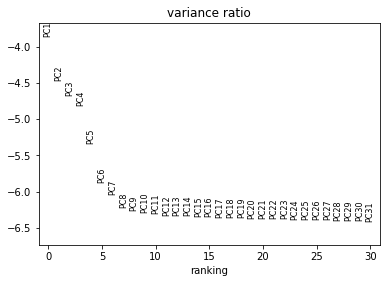

In [17]:
# Determining dimensionality
sc.pl.pca_variance_ratio(pbmc, log=True)

### UMAP/tSNE

In [18]:
sc.tl.tsne(pbmc, n_pcs = 10)

sc.pp.neighbors(pbmc, n_neighbors=10, n_pcs=10)
sc.tl.umap(pbmc)

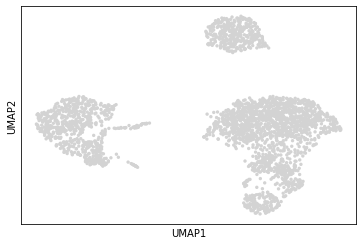

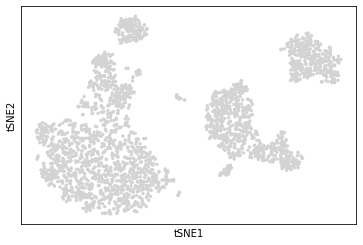

In [19]:
sc.pl.umap(pbmc)
sc.pl.tsne(pbmc)

### Clustering

In [20]:
sc.tl.leiden(pbmc, resolution = 0.4)

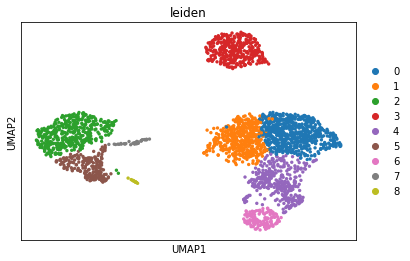

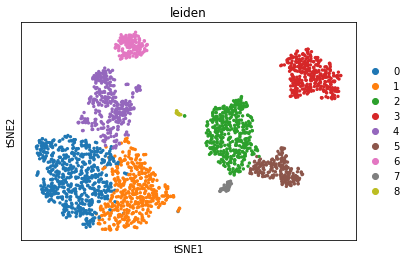

In [21]:
sc.pl.umap(pbmc, color = 'leiden')
sc.pl.tsne(pbmc, color = 'leiden')

### Assign cell type identities

In [22]:
new_cluster_names = [
    'Memory CD4 T', 'Naive CD4 T',
    'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'DC', 'Platelet']
pbmc.rename_categories('leiden', new_cluster_names)

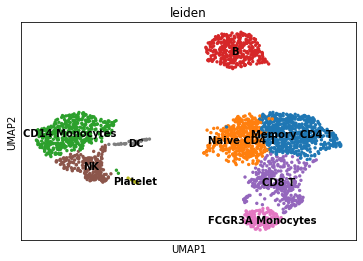

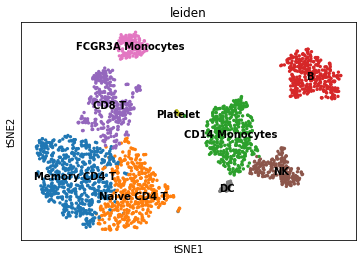

In [23]:
sc.pl.umap(pbmc, color='leiden', legend_loc='on data')
sc.pl.tsne(pbmc, color='leiden', legend_loc='on data')

## DPT

#### calculate diffusion map

In [24]:
sc.tl.diffmap(pbmc)

In [46]:
pbmc.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,leiden
AAACATACAACCAC-1,781,2421.0,73.0,3.015283,781,CD8 T
AAACATTGAGCTAC-1,1352,4903.0,186.0,3.793596,1352,B
AAACATTGATCAGC-1,1131,3149.0,28.0,0.889171,1131,Naive CD4 T
AAACCGTGCTTCCG-1,960,2639.0,46.0,1.743085,960,NK
AAACCGTGTATGCG-1,522,981.0,12.0,1.223242,522,FCGR3A Monocytes
...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,3461.0,73.0,2.109217,1155,CD14 Monocytes
TTTCTACTGAGGCA-1,1227,3447.0,32.0,0.928343,1227,B
TTTCTACTTCCTCG-1,622,1684.0,37.0,2.197150,622,B
TTTGCATGAGAGGC-1,454,1024.0,21.0,2.050781,454,B


#### calculate diffusion psuedotime

In [69]:
pbmc.uns['iroot'] = np.flatnonzero(pbmc.obs['leiden'] == 'NK')[0]
sc.tl.dpt(pbmc, n_branchings = 2)

In [54]:
pbmc

AnnData object with n_obs × n_vars = 2638 × 2013
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'dpt_pseudotime'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'diffmap_evals', 'iroot'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

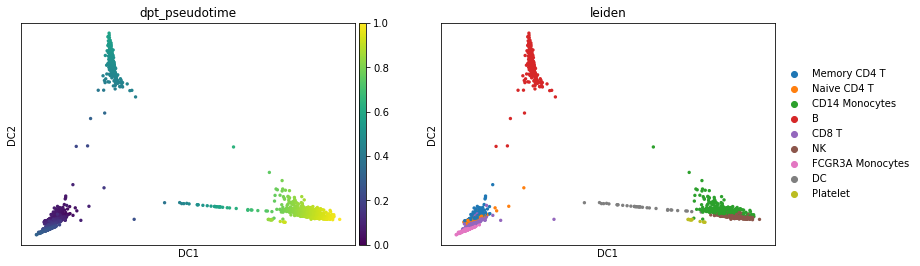

In [57]:
sc.pl.diffmap(pbmc, color=['dpt_pseudotime', 'leiden'])

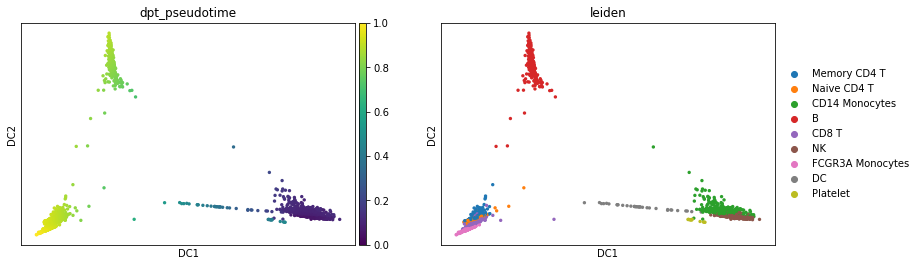

In [70]:
sc.pl.diffmap(pbmc, color=['dpt_pseudotime', 'leiden'])